## Introduction
Hi, this is my first notebook post to kaggle. I'm looking for any and all advice, thanks :D

## Exploratory Analysis

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

There is 1 csv file in the current version of the dataset:


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/city_temperature.csv


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [4]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [5]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: /kaggle/input/city_temperature.csv

In [6]:
nRowsRead = None # specify 'None' if want to read whole file
# city_temperature.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/kaggle/input/city_temperature.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'city_temperature.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 2906327 rows and 8 columns


Let's take a quick look at what the data looks like:

In [7]:
df1.head(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [8]:
df1.isnull().sum()

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

We have unknown values for state. A possible solution to this would be to use the city, state, country, region to look up a pair of coordinates and then use that for our model. For simplicity sake, lets just drop the state column

In [9]:
df1.describe().round(1)

,Month,Day,Year,AvgTemperature
count,2906327.0,2906327.0,2906327.0,2906327.0
mean,6.5,15.7,2006.6,56.0
std,3.5,8.8,23.4,32.1
min,1.0,0.0,200.0,-99.0
25%,3.0,8.0,2001.0,45.8
50%,6.0,16.0,2007.0,62.5
75%,9.0,23.0,2013.0,75.5
max,12.0,31.0,2020.0,110.0


Here we see that the minimum values for 'Year' and 'AvgTemperature' are very wrong, lets see in detail with a boxplot

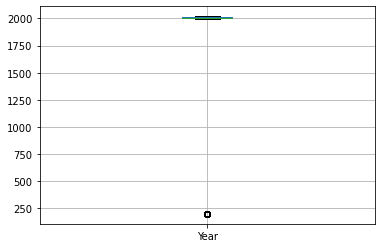

In [10]:
df1.boxplot(column='Year')

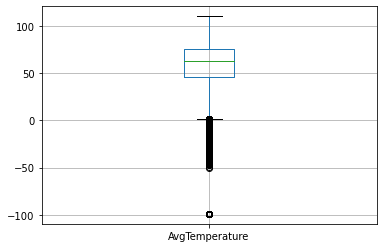

In [11]:
df1.boxplot(column='AvgTemperature')

-99 degrees and year 200 are obvious typos/placeholders, lets remove those columns.

In [12]:
print((df1['Year'] == 200).sum())
print((df1['AvgTemperature'] == -99).sum())

89
79672


imputing these missing values might give our model bias. Since we only have about 80,000 bad rows, and we have 3million total rows, we can drop these 

In [13]:
df1 = df1.drop(df1[(df1.Year == 200) | (df1.AvgTemperature == -99)].index)
df1 = df1.drop('State',1)
df1.head()

,Region,Country,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,Algiers,1,1,1995,64.2
1,Africa,Algeria,Algiers,1,2,1995,49.4
2,Africa,Algeria,Algiers,1,3,1995,48.8
3,Africa,Algeria,Algiers,1,4,1995,46.4
4,Africa,Algeria,Algiers,1,5,1995,47.9


In [14]:
df1.groupby(['Year']).count()[['AvgTemperature']]

,AvgTemperature
Year,
1995,112152
1996,112734
1997,112952
1998,111102
1999,113406
2000,114169
2001,115277
2002,113616
2003,114283


We seem to have a good distribution of data points per year, nice.

Lets check if we have a good distribution of data points per city.

In [15]:
df1[(df1.Year != 2020)].groupby(['City','Year'])[['AvgTemperature']].count().describe()

,AvgTemperature
count,7680.000000
mean,363.009505
std,65.204843
min,1.000000
25%,363.000000
50%,365.000000
75%,365.000000
max,835.000000


Most cities have around 363 readings per year, meaning most cities were polled daily for their temperatures.

We've excluded 2020 from this because 2020 is not yet over, so we obviously have less datapoints for that year.

In [16]:
df1.groupby('Region').describe()['AvgTemperature']

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Africa,220919.0,74.402602,9.272693,33.3,68.6,76.8,81.3,102.8
Asia,306163.0,68.109723,19.722022,-37.2,57.7,75.6,82.7,103.7
Australia/South Pacific,55209.0,62.303693,9.715458,30.7,55.4,62.1,69.4,96.8
Europe,368702.0,51.947171,15.184031,-20.4,41.1,52.6,63.1,102.5
Middle East,120811.0,73.840683,16.798443,3.2,62.8,74.6,87.0,110.0
North America,1548160.0,56.150198,19.320096,-50.0,42.5,58.5,71.8,107.7
South/Central America & Carribean,206691.0,72.202024,10.780375,32.8,66.6,74.8,80.5,97.4


We have many more data points for North America than other regions of the world, this may mean our model might have a bias towards north american temperatures, seasons, etc.

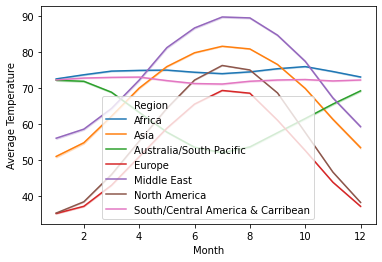

In [17]:
ax = sns.lineplot(x = 'Month', y = 'AvgTemperature', hue = 'Region', data = df1[(df1.Year != 2020)])
ax.set(xlabel = 'Month', ylabel='Average Temperature')
plt.show()

Here we see the inverse relationship between seasons in different hemispheres

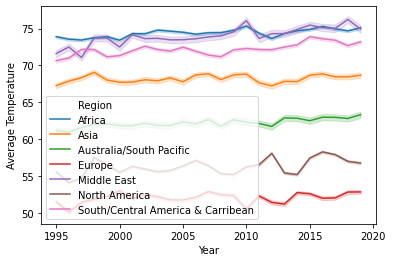

In [18]:
ax = sns.lineplot(x = 'Year', y = 'AvgTemperature', hue = 'Region', data = df1[(df1.Year != 2020)])
ax.set(xlabel = 'Year', ylabel='Average Temperature')
plt.show()

In this graph, we see how the different regions compare in terms of average temperature over time

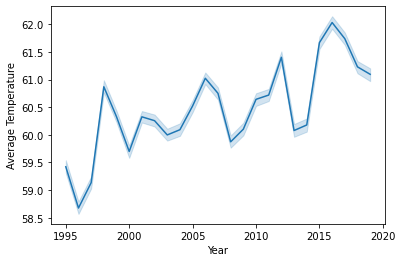

In [19]:
ax = sns.lineplot(x = 'Year', y = 'AvgTemperature', data = df1[(df1.Year != 2020)])
ax.set(xlabel = 'Year', ylabel='Average Temperature')
plt.show()

We see a slight upwards trend towards higher temperature as the years increase. 2020 wasn't included in these graphs once again, because we don't have the whole year to compare to other years.

# Preparing data for model

Since we want our model to predict the future, we'll train it on years 1995 - 2014 then validate on years 2015 to 2019 and use 2020 as our test

In [20]:
X = df1.copy()
y = X.AvgTemperature

X_train = X[(X.Year < 2015)].copy()
X_valid = X[(X.Year > 2014) & (X.Year != 2020)].copy()
X_test = X[(X.Year == 2020)].copy()

y_train = X_train.AvgTemperature
y_valid = X_valid.AvgTemperature
y_test = X_test.AvgTemperature

X_train.drop(['AvgTemperature'], axis=1, inplace=True)
X_valid.drop(['AvgTemperature'], axis=1, inplace=True)
X_test.drop(['AvgTemperature'], axis=1, inplace=True)

In [21]:
print(X_train.Year.unique())
print(X_valid.Year.unique())
print(X_test.Year.unique())

[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014]
[2015 2016 2017 2018 2019]
[2020]


In [22]:
from sklearn.preprocessing import LabelEncoder

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
label_X_test = X_test.copy()

label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])
    label_X_test[col] = label_encoder.transform(X_test[col])

In [23]:
label_X_train.head()

,Region,Country,City,Month,Day,Year
0,0,1,7,1,1,1995
1,0,1,7,1,2,1995
2,0,1,7,1,3,1995
3,0,1,7,1,4,1995
4,0,1,7,1,5,1995


# Training and testing our model

In [24]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

model = XGBRegressor(n_estimators=1000,learning_rate=0.05,n_jobs=-1)
model.fit(label_X_train,y_train, early_stopping_rounds=5, eval_set=[(label_X_valid,y_valid)])
predictions = model.predict(label_X_test)
mae = mean_absolute_error(predictions,y_test)
print("Mean Absolute Error:" , mae)

[0]	validation_0-rmse:60.90761
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:58.04028
[2]	validation_0-rmse:55.33026
[3]	validation_0-rmse:52.75720
[4]	validation_0-rmse:50.32101
[5]	validation_0-rmse:48.01041
[6]	validation_0-rmse:45.81779
[7]	validation_0-rmse:43.74538
[8]	validation_0-rmse:41.78392
[9]	validation_0-rmse:39.92568
[10]	validation_0-rmse:38.16533
[11]	validation_0-rmse:36.49858
[12]	validation_0-rmse:34.92609
[13]	validation_0-rmse:33.43530
[14]	validation_0-rmse:32.03000
[15]	validation_0-rmse:30.70193
[16]	validation_0-rmse:29.44800
[17]	validation_0-rmse:28.26596
[18]	validation_0-rmse:27.14996
[19]	validation_0-rmse:26.09219
[20]	validation_0-rmse:25.10442
[21]	validation_0-rmse:24.17560
[22]	validation_0-rmse:23.30081
[23]	validation_0-rmse:22.47729
[24]	validation_0-rmse:21.70173
[25]	validation_0-rmse:20.95285
[26]	validation_0-rmse:20.26916
[27]	validation_0-rmse:19.62010
[28]	validation_0-rmse:19.02117
[29]	validation_0-

In [25]:
pd.DataFrame(predictions).head()

,0
0,51.609955
1,51.567406
2,51.567406
3,51.567406
4,51.502556


In [26]:
pd.DataFrame(y_test).head()

,AvgTemperature
9132,46.3
9133,45.4
9134,48.0
9135,53.4
9136,47.3
